# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from datetime import datetime, timedelta, date
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model
import tensorflow as tf
from keras.layers import Dropout


# Set random seed
np.random.seed(0)
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

## Read The Data

In [3]:
df = pd.read_excel( r'C:\Users\MMM-SM\21Pypractice\project\DEXINUS.xls',
                   skiprows=10,
                   index_col=[0],
                   parse_dates=True)
df.head(10)

,DEXINUS
observation_date,
1973-01-02,8.02
1973-01-03,8.02
1973-01-04,8.00
1973-01-05,8.01
1973-01-08,8.00
1973-01-09,8.00
1973-01-10,8.00
1973-01-11,8.00
1973-01-12,8.00


In [4]:
#Fill missing values using interpolation
df['DEXINUS'].interpolate(method='linear',
                          limit_direction='forward',
                          inplace=True)

In [5]:
# df.isna().sum()

# Scaling and Splitting - Train test split

In [6]:
# Applying the minmax scaler for scaling of the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
data1 = scaler.transform(df)
data1

array([[0.01189794],
       [0.01189794],
       [0.01161124],
       ...,
       [0.95957569],
       [0.95971904],
       [0.95971904]])

In [7]:
len(data1)

12649

In [8]:
# Train and Test split

train_size = int(12649-525)  #95% for training
print(train_size,len(data1),type(data1))

train = data1[:train_size]
test = data1[train_size:]

X_train = train[:-1] # Creating train data by expellig the last record. making it yesterday's data
y_train = train[1:]  # Creating train data by expelling the first record. making it next day's data

X_test = test[:-1] # Creating test data by expellig the last record. making it yesterday's data
y_test = test[1:]  # Creating test data by expelling the first record. making it next day's data
len(X_train),len(X_test), len(y_train), len(y_test)

12124 12649 <class 'numpy.ndarray'>


(12123, 524, 12123, 524)

In [9]:
# pd.DataFrame(zip(X_train,y_train))
print(train[-3:],end='\n')
print(test[:5])

[[0.89521216]
 [0.89234518]
 [0.89449541]]
[[0.890625  ]
 [0.88976491]
 [0.88861812]
 [0.88618119]
 [0.88489106]]


# Model Building

## Artificial Neural Network - ANN

In [10]:
# Defining custom function for Adjusted R-Squared

def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))

### Initialize the model

In [11]:
# Initiate the ANN Network Components

K.clear_session()

model = Sequential()
model.add(Dense(30, input_dim=1, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


### Compile and Train the model

In [12]:
# Compile the model with relevent ealuation metrics

model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
              optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=8, verbose=1)

# Training the model with Train Dataset

history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=1,
                    verbose=1,
                    callbacks=[early_stop],
                    shuffle=False,
                    ) #workers=5

Epoch 1/100
12123/12123 [==============================] - 27s 801us/step - loss: 6.3781e-06 - rmse: 0.0020
Epoch 2/100
12123/12123 [==============================] - 9s 762us/step - loss: 0.0025 - rmse: 0.0172
Epoch 3/100
12123/12123 [==============================] - 9s 782us/step - loss: 0.0012 - rmse: 0.0155
Epoch 4/100
12123/12123 [==============================] - 10s 787us/step - loss: 5.2064e-04 - rmse: 0.0138
Epoch 5/100
12123/12123 [==============================] - 10s 788us/step - loss: 2.8960e-04 - rmse: 0.0125
Epoch 6/100
12123/12123 [==============================] - 10s 788us/step - loss: 2.0704e-04 - rmse: 0.0115
Epoch 7/100
12123/12123 [==============================] - 9s 782us/step - loss: 1.3356e-04 - rmse: 0.0107
Epoch 8/100
12123/12123 [==============================] - 10s 789us/step - loss: 7.5823e-05 - rmse: 0.0101
Epoch 9/100
12123/12123 [==============================] - 9s 780us/step - loss: 1.1203e-04 - rmse: 0.0096
Epoch 00009: early stopping


### Check the performance metrics

In [13]:
from sklearn.metrics import r2_score

# Defining MAPE for calculating Mean Absolute Percentage Error (MAPE)

def MAPE(y,yhat):
    return np.mean(np.abs((y - yhat)/y)*100)

# Calculating Performance metrics on Train Data.

y_train_pred = scaler.inverse_transform(model.predict(X_train))
train_mse = metrics.mean_squared_error(scaler.inverse_transform(y_train), y_train_pred)
rmse_train = np.sqrt(train_mse)

print(' \033[7m On Train Data \033[0m\n')
print("The  R2 score on the Train set is :\t{:0.3f}".format(
    r2_score(scaler.inverse_transform(y_train), y_train_pred)))
print("The  MAE on the Train set is      :\t{:0.3f}".format(
    metrics.mean_absolute_error(scaler.inverse_transform(y_train), y_train_pred)))

print("The  RMSE on the Train set is     :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(scaler.inverse_transform(y_train), y_train_pred)

print("The  MAPE on the Train Set is     :\t{:.3f}%"\
      .format(MAPE(scaler.inverse_transform(y_train),y_train_pred)))

# Calculating Performance metrics on Test Data.

y_pred_test = scaler.inverse_transform(model.predict(X_test))
test_mse = metrics.mean_squared_error(scaler.inverse_transform(y_test), y_pred_test)
rmse_test = np.sqrt(test_mse)

print('\n\n \033[7m On Test Data \033[0m\n')
print("The  R2 score on the Test set is  :\t{:0.3f}".format(
    r2_score(scaler.inverse_transform(y_test), y_pred_test)))
r2_test = r2_score(scaler.inverse_transform(y_test), y_pred_test)

print("The  MAE on the Test set is       :\t{:0.3f}".format(
    metrics.mean_absolute_error(scaler.inverse_transform(y_test), y_pred_test)))
print("The  RMSE on the Test set is      :\t{:0.3f}".format(rmse_test))

print("The  MAPE on the Test Set is     :\t{:.3f}%".\
      format(MAPE(scaler.inverse_transform(y_test),y_pred_test)))

  On Train Data 

The  R2 score on the Train set is :	0.920
The  MAE on the Train set is      :	4.946
The  RMSE on the Train set is     :	5.624
The  MAPE on the Train Set is     :	36.151%


  On Test Data 

The  R2 score on the Test set is  :	0.891
The  MAE on the Test set is       :	0.534
The  RMSE on the Test set is      :	0.622
The  MAPE on the Test Set is     :	0.723%


### Plotting the prediction vs actuals on Test data

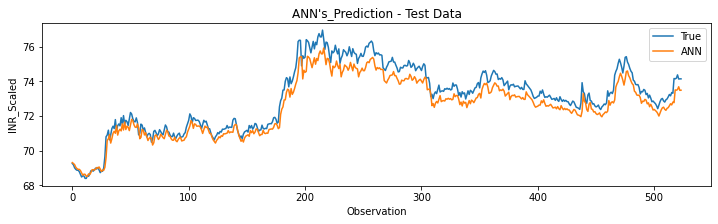

In [14]:
plt.figure(figsize=(12, 3))
plt.plot(scaler.inverse_transform(y_test), label='True')
plt.plot(y_pred_test, label='ANN')
# plt.plot(rate_data_log[:10118].index,y_train, label='True')
# plt.plot(rate_data_log[:10118].index,y_train_pred, label='ANN')
plt.title("ANN's_Prediction - Test Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [15]:
Temp = pd.concat([
    pd.DataFrame(scaler.inverse_transform(y_test), columns=['yTrue']),
    pd.DataFrame(y_pred_test, columns=['yHat'])
    ],
                 axis=1)

Temp.tail(7)

,yTrue,yHat
517,74.16,72.766624
518,74.14,73.502769
519,74.18,73.485451
520,74.37,73.520088
521,74.13,73.684647
522,74.14,73.476791
523,74.14,73.485451


### Plotting prediciton vs Actuals on Train Data

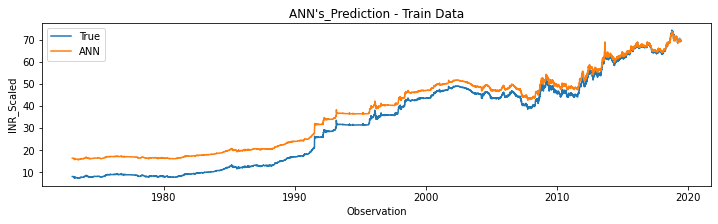

In [16]:
plt.figure(figsize=(12, 3))
# plt.plot(y_test, label='True')
# plt.plot(y_pred_test, label='ANN')
plt.plot(df[:12123].index, scaler.inverse_transform(y_train), label='True')
plt.plot(df[:12123].index, y_train_pred, label='ANN')
plt.title("ANN's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

## LSTM

Long Term Short Memory (LSTM) networks are another variant of RNNs. They are capable of retaining long term dependencies among the sequence of events or data points.

### Reshape the data for LSTM model

In [17]:
data2 = list(data1.reshape(12649))
train_size = int(12649-525)#12649-525
print(train_size,len(data2),type(data2), sep = ' -  ')

train1 = data2[:train_size]
test1 = data2[train_size:]

train_list = [x for x in train1]
predictions = []
len(train1),len(test1)

12124 -  12649 -  <class 'list'>


(12124, 525)

In [18]:
## Define a custom fuction to create a lagged array with custom lag size for LSTM model

def gen_XY(t_list, size):
    '''
    Generates an autoregressive lagged array.
    
    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.
    
    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.
    
    '''
    X = np.zeros([1, size])
    Y = []
    temp_list = []
    for i in range(len(t_list) - size):
        add_list = t_list[i:i + size]
        target = t_list[i + size]
        X = np.append(X, np.array([add_list]), axis=0)
        Y.append(target)

    X = np.delete(X, 0, axis=0)
    Y = np.array(Y)

    return X, Y.T

In [19]:
# Call the custom function and generate the train and test data

X_train, y_train = gen_XY(train1, 1)
X_test, y_test = gen_XY(test1, 1)

In [20]:
# Check y_train & y_test data shape
print(y_train.shape,y_test.shape,type(y_train),end='\n')

# print y_train & y_test data as is
print(y_train[:5], end='\n')

# reshape y_train for two dimentions
print(y_train.reshape(12123,-1))

(12123,) (524,) <class 'numpy.ndarray'>
[0.01189794 0.01161124 0.01175459 0.01161124 0.01161124]
[[0.01189794]
 [0.01161124]
 [0.01175459]
 ...
 [0.89521216]
 [0.89234518]
 [0.89449541]]


In [21]:
# Check the shape of Xtrain
X_train.shape

(12123, 1)

**LSTM Expect the data to be in 3 dimensions**

In [22]:
#LSTM Preprocessing
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [23]:
# Check the reshaped data

print(X_tr_t.shape,X_tst_t.shape)
X_tr_t[:5]

(12123, 1, 1) (524, 1, 1)


array([[[0.01189794]],

       [[0.01189794]],

       [[0.01161124]],

       [[0.01175459]],

       [[0.01161124]]])

### Model Initialization and Training

In [35]:
from keras.layers import LSTM

K.clear_session()
model_lstm = Sequential()
model_lstm.add(
    LSTM(50,
         input_shape=(1,X_train.shape[1]),
         activation='relu',
#          kernel_initializer='lecun_uniform',
         return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


**Observation:As we can see from the above code, we have used 50 neurons in the LSTM cell with activation function relu, kernel initializer lecun_uniform, and return sequence False.**

In [36]:
# Compile the model with relavent metrics
model_lstm.compile(
    loss=tf.keras.metrics.mean_squared_error,
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# Train the model with Train data
history_model_lstm = model_lstm.fit(X_tr_t,
                                    y_train,
                                    epochs=100,
                                    batch_size=1,
                                    verbose=1,
                                    shuffle=False,
                                    callbacks=[early_stop])

Epoch 1/100
12123/12123 [==============================] - 15s 1ms/step - loss: 6.0406e-06 - rmse: 0.0019
Epoch 2/100
12123/12123 [==============================] - 14s 1ms/step - loss: 0.0024 - rmse: 0.0168
Epoch 3/100
12123/12123 [==============================] - 14s 1ms/step - loss: 0.0011 - rmse: 0.0151
Epoch 4/100
12123/12123 [==============================] - 14s 1ms/step - loss: 5.9882e-04 - rmse: 0.0135
Epoch 5/100
12123/12123 [==============================] - 14s 1ms/step - loss: 3.8728e-04 - rmse: 0.0124
Epoch 6/100
12123/12123 [==============================] - 14s 1ms/step - loss: 2.6026e-04 - rmse: 0.0115
Epoch 00006: early stopping


### Checking the Accuracy of LSTM Model 

In [37]:
# Calculating performance metrics on Train data

y_train_pred_lstm = scaler.inverse_transform(model_lstm.predict(X_tr_t))
iy_train = scaler.inverse_transform(y_train.reshape(12123, -1))
train_mse = metrics.mean_squared_error(iy_train, y_train_pred_lstm)
rmse_train = np.sqrt(train_mse)

print(' \033[7mOn Train Data\033[0m\n')
print('-----------------------')
print("The R2 score on the Train set is           :\t{:0.3f}".format(
    r2_score(iy_train, y_train_pred_lstm)))
print("The MAE on the Train set is                :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_train, y_train_pred_lstm)))

print("The RMSE on the Train set is               :\t{:0.3f}".format(
    rmse_train))
r2_train = r2_score(iy_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is  :\t{:0.3f}".format(
    adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print('The MAPE on Train set is                   :\t{:.3f} %\n'.format(
    MAPE(iy_train, y_train_pred_lstm)))

# Calculating performance metrics on Test data

y_pred_test_lstm = scaler.inverse_transform(model_lstm.predict(X_tst_t))
iy_test = scaler.inverse_transform(y_test.reshape(524, -1))
test_mse = metrics.mean_squared_error(iy_test, y_pred_test_lstm)
rmse_test = np.sqrt(test_mse)

print('\n\n \033[7mOn Test Data\033[0m\n')
print(' ----------------------')
print("The R2 score on the Test set is            :\t{:0.3f}".format(
    r2_score(iy_test, y_pred_test_lstm)))
r2_test = r2_score(iy_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is   :\t{:0.3f}".format(
    adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The MAE on the Test set is                 :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_test, y_pred_test_lstm)))
print("The RMSE on the Test set is                :\t{:0.3f}".format(
    rmse_test))
print('The MAPE on the Test Set is                :\t{:.3f} %'.format(
    MAPE(iy_test, y_pred_test_lstm)))

 On Train Data

-----------------------
The R2 score on the Train set is           :	0.864
The MAE on the Train set is                :	5.789
The RMSE on the Train set is               :	7.360
The Adjusted R2 score on the Train set is  :	0.863
The MAPE on Train set is                   :	48.511 %



 On Test Data

 ----------------------
The R2 score on the Test set is            :	0.979
The Adjusted R2 score on the Test set is   :	0.979
The MAE on the Test set is                 :	0.193
The RMSE on the Test set is                :	0.270
The MAPE on the Test Set is                :	0.264 %


### Plotting the prediction vs Actual on Test Data

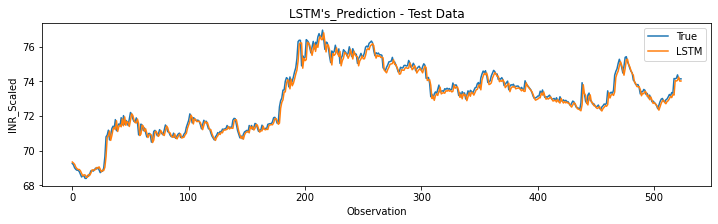

In [27]:
plt.figure(figsize=(12, 3))
plt.plot(iy_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction - Test Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### Plotting Prediction vs Actuals on Train Data

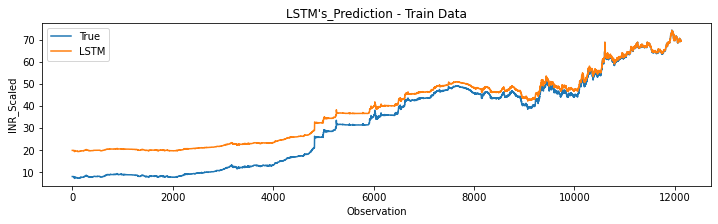

In [28]:
plt.figure(figsize=(12, 3))
plt.plot(iy_train, label='True')
plt.plot(y_train_pred_lstm, label='LSTM')
plt.title("LSTM's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

As we can see from above plot, LSTM performs well for test data than ANN. IT can be ovserved that on Train data LSTM tries to keep the most recent information for prediction and predicts the nearterm better than the past. 

## Gated Recurrent Unit - GRU

Gated Recurrent Unit (GRU) and LSTM both have the characterstics to retain the long term dependency of past sequence of events. The major difference between the two is LSTMs control the exposure of memory content (cell state) while GRUs expose the entire cell state to other units in the network.

We can use the same data shape of LSTM for GRU hence we can directly prodeceed to model building.

### Initialization of GRU Model

In [50]:
#GRU
from keras.layers import GRU

K.clear_session()
model_gru = Sequential()
model_gru.add(
    GRU(7,
        input_shape=(1, X_train.shape[1]),
        activation='linear',
        kernel_initializer='lecun_uniform',
        return_sequences=False))
model_gru.add(Dense(1))
model_gru.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7)                 210       
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


**We have build a light weight GRU model having only 7 neurons in hidden layer due to which total model parameters are only 218**

In [51]:
# Compile the model with relavent parametres

model_gru.compile(loss=tf.keras.metrics.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
                  optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

# Train the model
history_model_gru = model_gru.fit(X_tr_t,
                                  y_train,
                                  epochs=100,
                                  batch_size=1,
                                  verbose=1,
                                  shuffle=False,
                                  callbacks=[early_stop])

Epoch 1/100
12123/12123 [==============================] - 14s 1ms/step - loss: 4.9807e-06 - rmse: 0.0021
Epoch 2/100
12123/12123 [==============================] - 13s 1ms/step - loss: 4.1834e-04 - rmse: 0.0071
Epoch 3/100
12123/12123 [==============================] - 13s 1ms/step - loss: 2.2075e-04 - rmse: 0.0066
Epoch 4/100
12123/12123 [==============================] - 13s 1ms/step - loss: 1.4850e-04 - rmse: 0.0062
Epoch 5/100
12123/12123 [==============================] - 13s 1ms/step - loss: 1.1759e-04 - rmse: 0.0059
Epoch 6/100
12123/12123 [==============================] - 13s 1ms/step - loss: 1.0277e-04 - rmse: 0.0057
Epoch 00006: early stopping


### Check the accuracy on both train and test

In [52]:
# Calculating the performance metrics for test data

y_train_pred_gru = scaler.inverse_transform(model_gru.predict(X_tr_t))
train_mse = metrics.mean_squared_error(iy_train, y_train_pred_gru)
rmse_train = np.sqrt(train_mse)

print('\n \033[7mThe Score on Train Data\033[0m')
print(' ----------------------')

print("The R2 score on the Train set is            :\t{:0.3f}".format(
    r2_score(iy_train, y_train_pred_gru)))
print("The  MAE on the Train set is                :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_train, y_train_pred_gru)))

print("The  RMSE on the Train set is               :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(iy_train, y_train_pred_gru)
print("The Adjusted R2 score on the Train set is   :\t{:0.3f}".format(
    adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print('The MAPE on the Train set is                :\t{:.3f} %\n'.format(
    MAPE(iy_train,y_train_pred_gru)))

# Calculating the performance metrics for test data

y_pred_test_gru = scaler.inverse_transform(model_gru.predict(X_tst_t))
test_mse = metrics.mean_squared_error(iy_test, y_pred_test_gru)
rmse_test = np.sqrt(test_mse)

print('\n\n \033[7mThe Score on Test Data\033[0m')
print(' ---------------------')
print("The R2 score on the Test set is             :\t{:0.3f}".format(
    r2_score(iy_test, y_pred_test_gru)))
r2_test = r2_score(iy_test, y_pred_test_gru)
print("The Adjusted R2 score on the Test set is    :\t{:0.3f}".format(
    adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))
print("The  MAE on the Test set is                 :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_test, y_pred_test_gru)))
print("The  RMSE on the Test set is                :\t{:0.3f}".format(rmse_test))
print('The MAPE on Test set is                     :\t{:.3f} %'.format(
    MAPE(iy_test,y_pred_test_gru)))


 The Score on Train Data
 ----------------------
The R2 score on the Train set is            :	0.916
The  MAE on the Train set is                :	4.536
The  RMSE on the Train set is               :	5.777
The Adjusted R2 score on the Train set is   :	0.916
The MAPE on the Train set is                :	38.116 %



 The Score on Test Data
 ---------------------
The R2 score on the Test set is             :	0.980
The Adjusted R2 score on the Test set is    :	0.980
The  MAE on the Test set is                 :	0.188
The  RMSE on the Test set is                :	0.263
The MAPE on Test set is                     :	0.257 %


### plotting the prediction vs actuals on Test Data

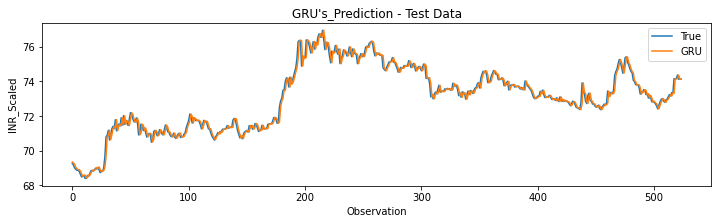

In [53]:
#GRU Prediction PLot
plt.figure(figsize=(12, 3))
plt.plot(iy_test, label='True')
plt.plot(y_pred_test_gru, label='GRU')
plt.title("GRU's_Prediction - Test Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### Plotting the Prediction vs Actuals on the Train Data

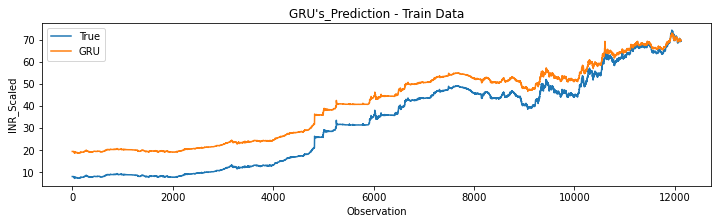

In [33]:
plt.figure(figsize=(12, 3))
plt.plot(iy_train, label='True')
plt.plot(y_train_pred_gru, label='GRU')
plt.title("GRU's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')

plt.legend()
plt.show()

In [54]:
print('\n \033[7mComparing all the Neural Network Models\033[0m')
print(' ---------------------------------------\n')

print('''"The MAPE on ANN model is \t: \t 0.784%"
"The MAPE on GRU model is \t: \t 0.257%"
"The MAPE on LSTM model is \t: \t 0.264%"''')


 Comparing all the Neural Network Models
 ---------------------------------------

"The MAPE on ANN model is 	: 	 0.784%"
"The MAPE on GRU model is 	: 	 0.257%"
"The MAPE on LSTM model is 	: 	 0.264%"


# Building the final model with full data -> see another notebook